In [181]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt


# this is the funstion to set seed value which will ensure consistent results
def set_seed(seed_value):
    np.random.seed(seed_value)

# this is the seed value which will ensure consistent results
seed_value = 9  
set_seed(seed_value) 

# Ensure inline plotting in Jupyter
%matplotlib inline


In [182]:
# this function would load all images from the Ass2 folder the current folder in the current directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"): 
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((filename, img))
                print(f"Loaded image: {filename}")  
            else:
                print(f"Failed to load image: {filename}") 
    return images

folder = './Ass2' 
images = load_images_from_folder(folder)

if not images:
    print("No images found in the folder.")


Loaded image: T22.jpg
Loaded image: T32.jpg
Loaded image: T42.jpg
Loaded image: T52.jpg
Loaded image: T62.jpg


In [183]:
# this function is for Otsu multilevel thresholding
def otsu_multilevel_thresholding(image, levels):
    thresholds = []
    current_image = image.copy()

    for _ in range(levels - 1):
        thresh_value, _ = cv2.threshold(current_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(thresh_value)
        current_image = np.where(current_image >= thresh_value, 0, current_image)

    segmented_image = np.zeros_like(image)
    for i, thresh in enumerate(sorted(thresholds)):
        segmented_image[np.where(image >= thresh)] = (i + 1) * (255 // levels)

    return segmented_image, thresholds

# this function is for Kapur multilevel thresholding
def kapur_threshold(image, levels):
    # calculating histogramn for image and normalising it
    hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 256])
    hist_sum = hist.sum()

    # handles error case where sum oif of histogram is 0
    if hist_sum == 0:
        print("Warning: Histogram sum is zero, no thresholding possible.")
        return None, None 

    hist = hist.astype(np.float32) / hist_sum

    # calculates entropy
    def entropy(thresh):
        prob1 = hist[:thresh].sum()
        prob2 = hist[thresh:].sum()
        
        # checking if log is not undefined
        prob1 = prob1 if prob1 > 0 else 1e-10
        prob2 = prob2 if prob2 > 0 else 1e-10
        
        
        return -(np.log(prob1) * prob1 + np.log(prob2) * prob2)

    thresholds = []
    
    for _ in range(levels - 1):
        # this section would calculate entropy for all possible threshold values
        entropies = [entropy(thresh) for thresh in range(1, 255)]
        
        # does error handling for NaN values
        if np.any(np.isnan(entropies)):
            print("Warning: NaN detected in entropy calculation")
            return None, None

        # this section would find the best threshold that maximizes the entropy
        best_thresh = np.argmax(entropies)
        thresholds.append(best_thresh)
        
        hist[:best_thresh] = 0

    # this section would sort the thresholds and add 0 and 255 as boundaries
    thresholds = sorted(thresholds)
    thresholds = [0] + thresholds + [255]

    # this section would segment the image based on the thresholds
    segmented_image = np.zeros_like(image)
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i + 1])
        segmented_image[mask] = (i + 1) * (255 // levels)

    # this section would normalise the segmented image for better visualisation
    normalized_segmented_image = cv2.normalize(segmented_image, None, 0, 255, cv2.NORM_MINMAX)

    return normalized_segmented_image, thresholds

In [184]:
# this function is for the Simulated Annealing algorithm used for thresholding optimisation
def simulated_annealing(image, objective_function, levels, initial_temperature=1000, cooling_rate=0.99):
    def perturb(thresholds):
        idx = np.random.randint(0, len(thresholds))
        thresholds[idx] += np.random.randint(-10, 10)
        thresholds = np.clip(thresholds, 0, 255)
        return thresholds

    current_thresholds = np.sort(np.random.randint(0, 255, size=(levels - 1)))
    current_cost = objective_function(image, current_thresholds)
    temperature = initial_temperature

    while temperature > 1:
        new_thresholds = perturb(current_thresholds.copy())
        new_cost = objective_function(image, new_thresholds)

        if new_cost < current_cost or np.random.random() < np.exp((current_cost - new_cost) / temperature):
            current_thresholds = new_thresholds
            current_cost = new_cost

        temperature *= cooling_rate

    return current_thresholds

# this function is for the Variable Neighbourhood Search algorith used for thresholding optimisation
def variable_neighborhood_search(image, objective_function, levels):
    current_thresholds = np.sort(np.random.randint(0, 255, size=(levels - 1)))
    best_cost = objective_function(image, current_thresholds)

    def local_search(thresholds):
        for i in range(len(thresholds)):
            for change in [-10, 10]:
                new_thresholds = thresholds.copy()
                new_thresholds[i] += change
                new_thresholds = np.clip(new_thresholds, 0, 255)
                new_cost = objective_function(image, new_thresholds)
                if new_cost < best_cost:
                    return new_thresholds, new_cost
        return thresholds, best_cost

    while True:
        new_thresholds, new_cost = local_search(current_thresholds)
        if new_cost < best_cost:
            current_thresholds = new_thresholds
            best_cost = new_cost
        else:
            break

    return current_thresholds

In [185]:
# this function would display the images 
def display_images(images, titles, cols=2, figsize=(5, 3)):  
    rows = (len(images) + cols - 1) // cols  # Calculate the number of rows dynamically
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    if rows == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # printing unique values for each image (valkues between thresholds)
            unique_values = np.unique(images[i])

            # Nthis section is to normalise the segmented images for better visualisation
            norm_img = cv2.normalize(images[i], None, 0, 255, cv2.NORM_MINMAX)
            
            if 'Original' in titles[i]:
                ax.imshow(norm_img, cmap='gray') 
            # this section would apply 'jet' colormap if there are 3 or more unique values (sections)
            elif len(unique_values) >= 3:
                ax.imshow(norm_img, cmap='jet', vmin=0, vmax=255)  # 'jet' colormap > 3
            else:
                ax.imshow(norm_img, cmap='gray')  # greyscale if < 3
            
            ax.set_title(titles[i], fontsize=9) 
        else:
            ax.axis('off') 
        ax.axis('off')  

    plt.tight_layout()
    plt.show()

# this function would display histograms
def display_histograms(images, titles, thresholds_list=None, cols=2, figsize=(5, 3)):
    rows = (len(images) + cols - 1) // cols  # Calculate the number of rows dynamically
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            hist_data, bins = np.histogram(images[i].ravel(), bins=256, range=[0, 256])
            
            ax.hist(images[i].ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
            
            # this section would add vertical lines for the thresholds
            if thresholds_list and thresholds_list[i] is not None:
                for thresh in thresholds_list[i]:
                    ax.axvline(x=thresh, color='red', linestyle='--', linewidth=1)  # dashed red line for each threshold
            
            if 'Original' in titles[i]: 
                ax.set_ylim(0, 2000)  
            else:
                ax.set_ylim(0, hist_data.max() * 1.1)
            
            ax.set_title(f'Histogram of {titles[i]}', fontsize=8)
            ax.set_xlabel('Pixel Intensity', fontsize=6)
            ax.set_ylabel('Frequency', fontsize=6)
            ax.grid(True)
        else:
            ax.axis('off')  
        ax.tick_params(axis='both', which='major', labelsize=6) 

    plt.tight_layout()
    plt.show()


# this function would log all the results from the images being processed
def log_results(df, image_name, level, method, optimization, thresholds, obj_value, ssim_value, psnr_value, unique_values):
    new_row = pd.DataFrame({
        'Image': [image_name], 
        'Level': [level], 
        'Method': [method], 
        'Optimization': [optimization], 
        'Thresholds': [thresholds], 
        'Unique Values': [unique_values],
        'Objective Value': [obj_value], 
        'SSIM': [ssim_value], 
        'PSNR': [psnr_value]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    return df


# Otsu objective function
def  otsu_objective(image, thresholds):
    thresholds = [0] + sorted(thresholds) + [255]
    total_var = 0
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i+1])
        region = image[mask]
        if len(region) > 0:
            total_var += np.var(region) * len(region)
    return total_var


# Kapur objective function
def kapur_objective(image, thresholds):
    thresholds = [0] + sorted(thresholds) + [255]
    total_entropy = 0

    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i+1])
    
        hist, _ = np.histogram(image[mask], bins=256, range=[0, 256])
        
        if hist.sum() == 0:
            continue  
        
        hist = hist.astype(np.float32) / hist.sum()
        
        entropy = -np.sum(hist * np.log(hist + 1e-10))
        
        # this section adds the entropy of this region to the total entropy
        total_entropy += entropy

    return -total_entropy  # Kapur's method maximizes entropy, so we return the negative value

# create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Image', 'Level', 'Method', 'Optimization', 'Thresholds', 'Objective Value', 'SSIM', 'PSNR'])


******** Processing image: T22.jpg ********
### Processing k=2 ###
Thresholds for T22_SA_Otsu_k2: [60]
Unique values for T22_SA_Otsu_k2: [  0 127]
Thresholds for T22_SA_Kapur_k2: [31]
Unique values for T22_SA_Kapur_k2: [  0 255]
Thresholds for T22_VNS_Otsu_k2: [58]
Unique values for T22_VNS_Otsu_k2: [  0 127]
Thresholds for T22_VNS_Kapur_k2: [105]
Unique values for T22_VNS_Kapur_k2: [  0 255]
### Processing k=3 ###
Thresholds for T22_SA_Otsu_k3: [33 94]
Unique values for T22_SA_Otsu_k3: [  0  85 170]
Thresholds for T22_SA_Kapur_k3: [190  77]
Unique values for T22_SA_Kapur_k3: [  0 128 255]
Thresholds for T22_VNS_Otsu_k3: [37 95]
Unique values for T22_VNS_Otsu_k3: [  0  85 170]
Thresholds for T22_VNS_Kapur_k3: [ 94 176]
Unique values for T22_VNS_Kapur_k3: [  0 128 255]
### Processing k=4 ###
Thresholds for T22_SA_Otsu_k4: [ 22  65 115]
Unique values for T22_SA_Otsu_k4: [  0  63 126 189]
Thresholds for T22_SA_Kapur_k4: [ 31 125  57]
Unique values for T22_SA_Kapur_k4: [  0  85 170 255]
Th

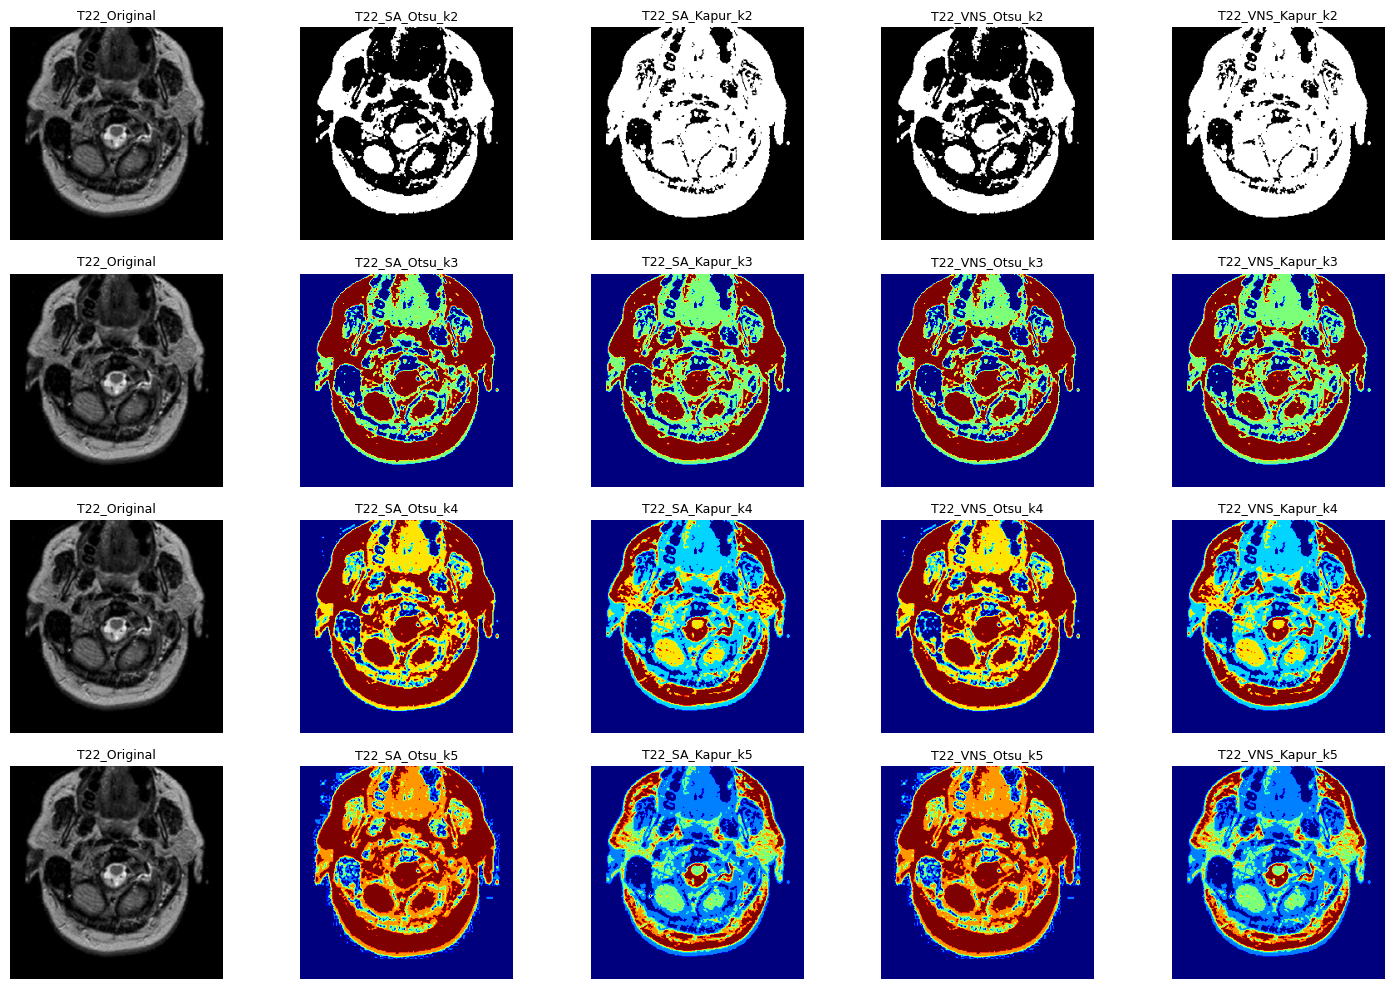

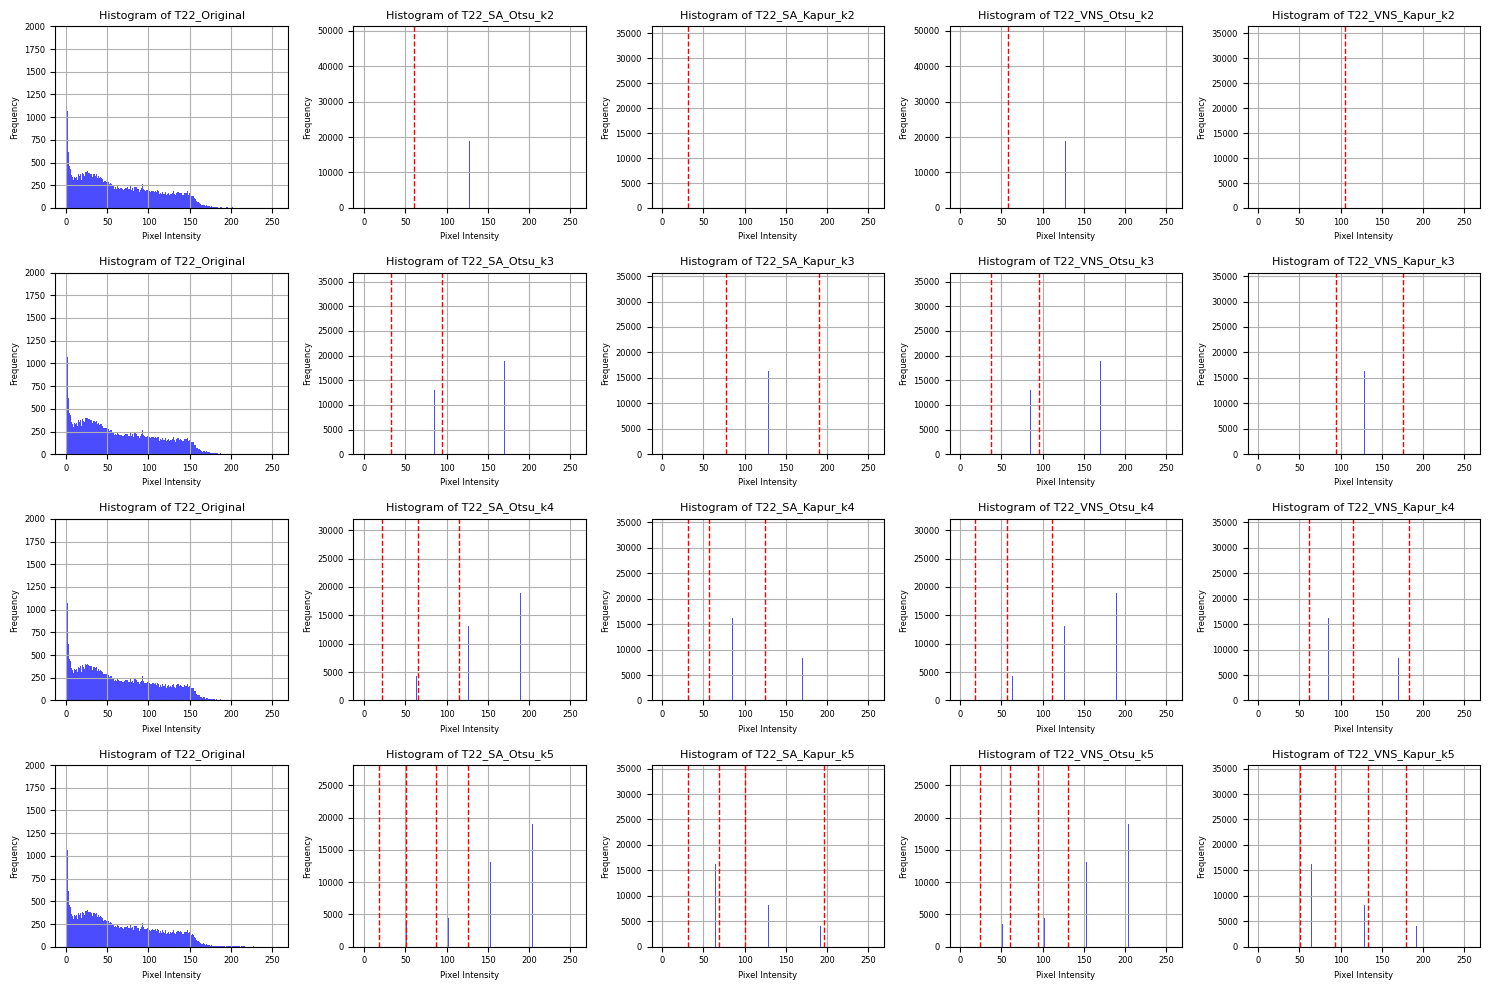

******** Processing image: T32.jpg ********
### Processing k=2 ###
Thresholds for T32_SA_Otsu_k2: [60]
Unique values for T32_SA_Otsu_k2: [  0 127]
Thresholds for T32_SA_Kapur_k2: [22]
Unique values for T32_SA_Kapur_k2: [  0 128 255]
Thresholds for T32_VNS_Otsu_k2: [65]
Unique values for T32_VNS_Otsu_k2: [  0 127]
Thresholds for T32_VNS_Kapur_k2: [116]
Unique values for T32_VNS_Kapur_k2: [  0 128 255]
### Processing k=3 ###
Thresholds for T32_SA_Otsu_k3: [ 42 109]
Unique values for T32_SA_Otsu_k3: [  0  85 170]
Thresholds for T32_SA_Kapur_k3: [23 36]
Unique values for T32_SA_Kapur_k3: [  0  85 170 255]
Thresholds for T32_VNS_Otsu_k3: [ 41 112]
Unique values for T32_VNS_Otsu_k3: [  0  85 170]
Thresholds for T32_VNS_Kapur_k3: [110 186]
Unique values for T32_VNS_Kapur_k3: [  0  85 170 255]
### Processing k=4 ###
Thresholds for T32_SA_Otsu_k4: [ 23  68 120]
Unique values for T32_SA_Otsu_k4: [  0  63 126 189]
Thresholds for T32_SA_Kapur_k4: [23 40 21]
Unique values for T32_SA_Kapur_k4: [  0 

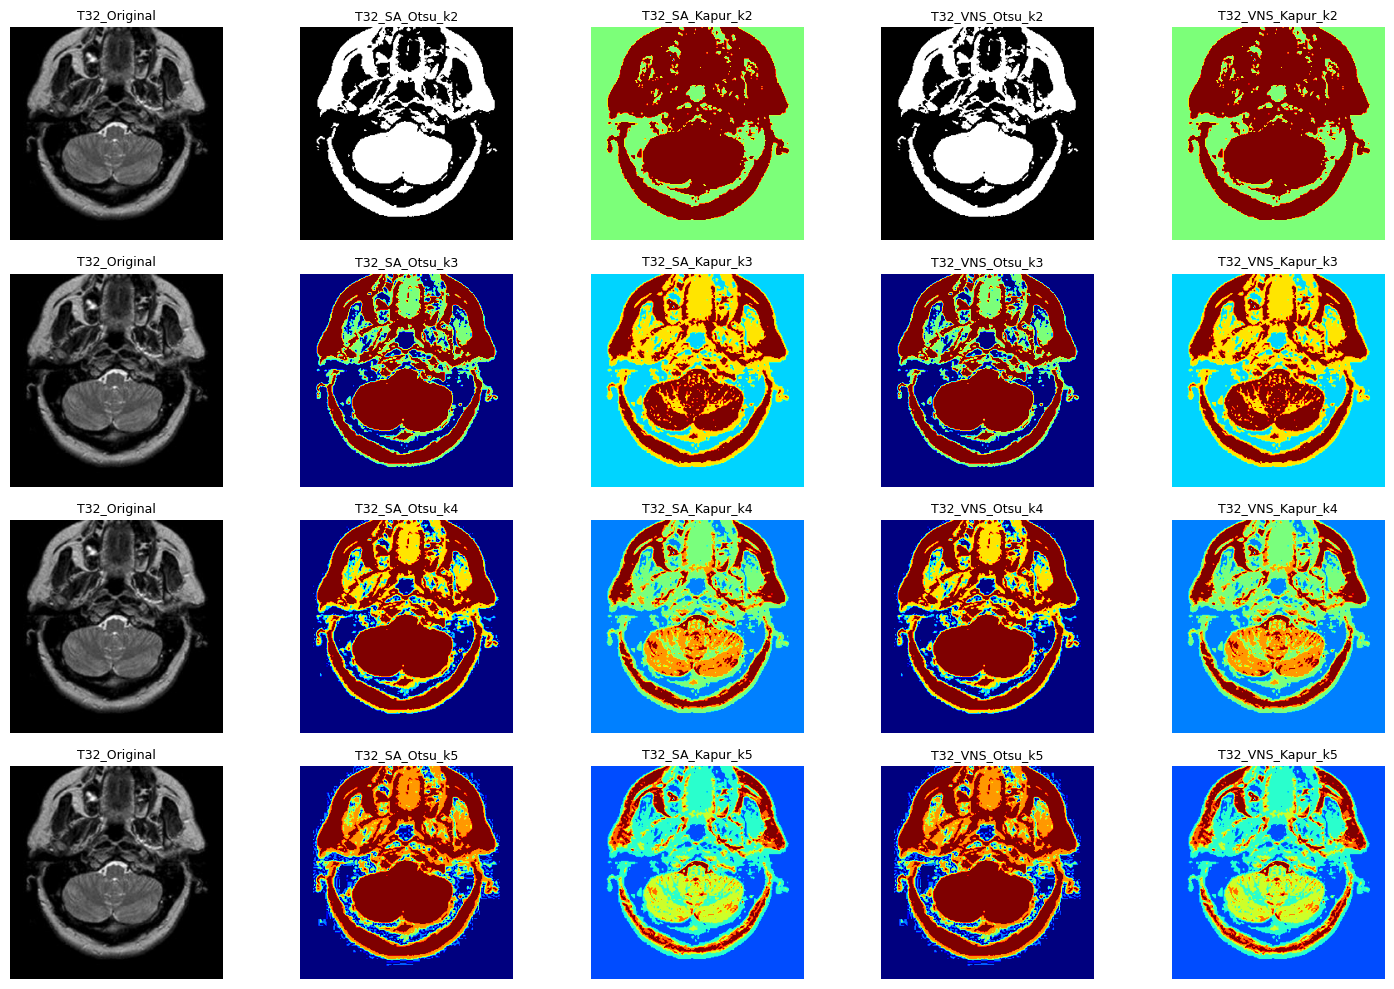

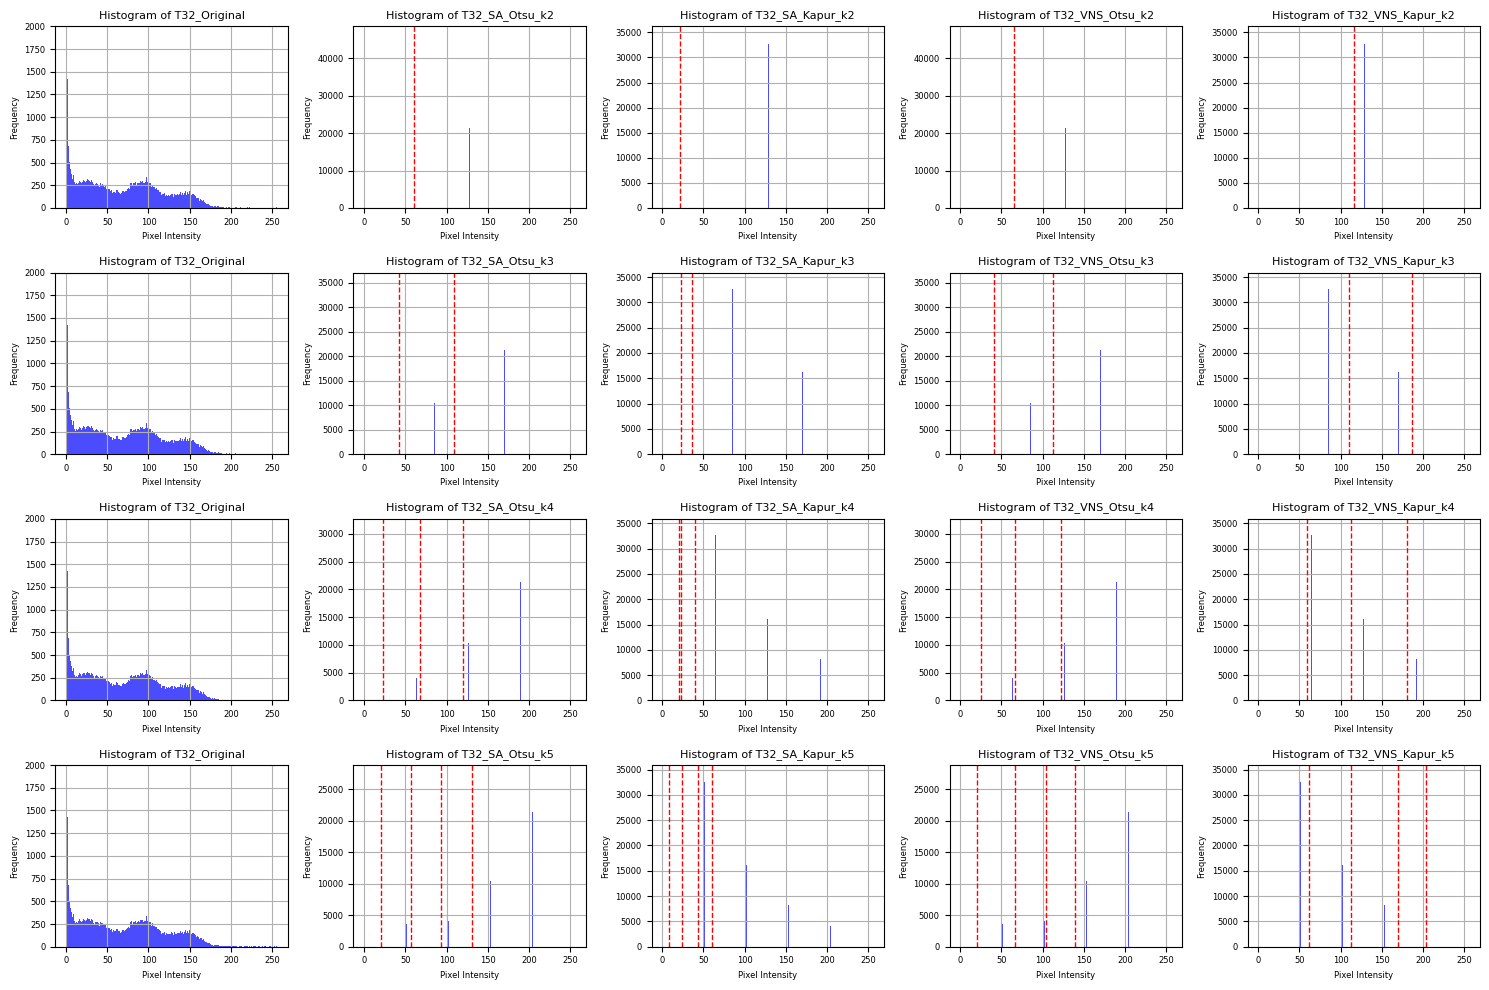

******** Processing image: T42.jpg ********
### Processing k=2 ###
Thresholds for T42_SA_Otsu_k2: [62]
Unique values for T42_SA_Otsu_k2: [  0 127]
Thresholds for T42_SA_Kapur_k2: [13]
Unique values for T42_SA_Kapur_k2: [  0 128 255]
Thresholds for T42_VNS_Otsu_k2: [64]
Unique values for T42_VNS_Otsu_k2: [  0 127]
Thresholds for T42_VNS_Kapur_k2: [124]
Unique values for T42_VNS_Kapur_k2: [  0 128 255]
### Processing k=3 ###
Thresholds for T42_SA_Otsu_k3: [ 46 120]
Unique values for T42_SA_Otsu_k3: [  0  85 170]
Thresholds for T42_SA_Kapur_k3: [46 43]
Unique values for T42_SA_Kapur_k3: [  0  85 170 255]
Thresholds for T42_VNS_Otsu_k3: [ 42 118]
Unique values for T42_VNS_Otsu_k3: [  0  85 170]
Thresholds for T42_VNS_Kapur_k3: [114 183]
Unique values for T42_VNS_Kapur_k3: [  0  85 170 255]
### Processing k=4 ###
Thresholds for T42_SA_Otsu_k4: [ 29  77 131]
Unique values for T42_SA_Otsu_k4: [  0  63 126 189]
Thresholds for T42_SA_Kapur_k4: [ 23 133  77]
Unique values for T42_SA_Kapur_k4: [ 

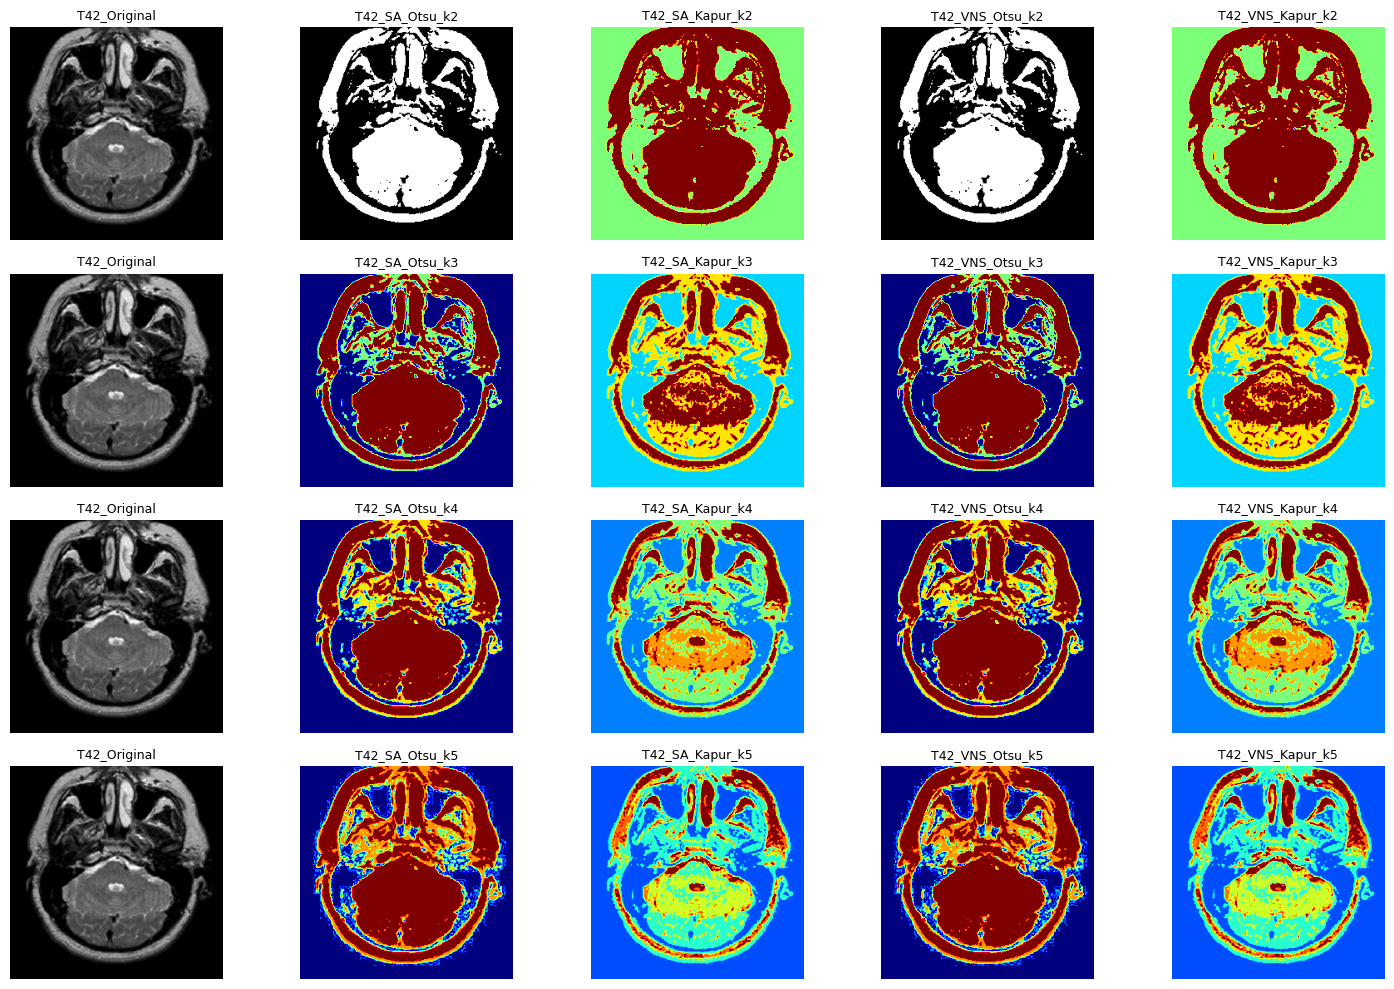

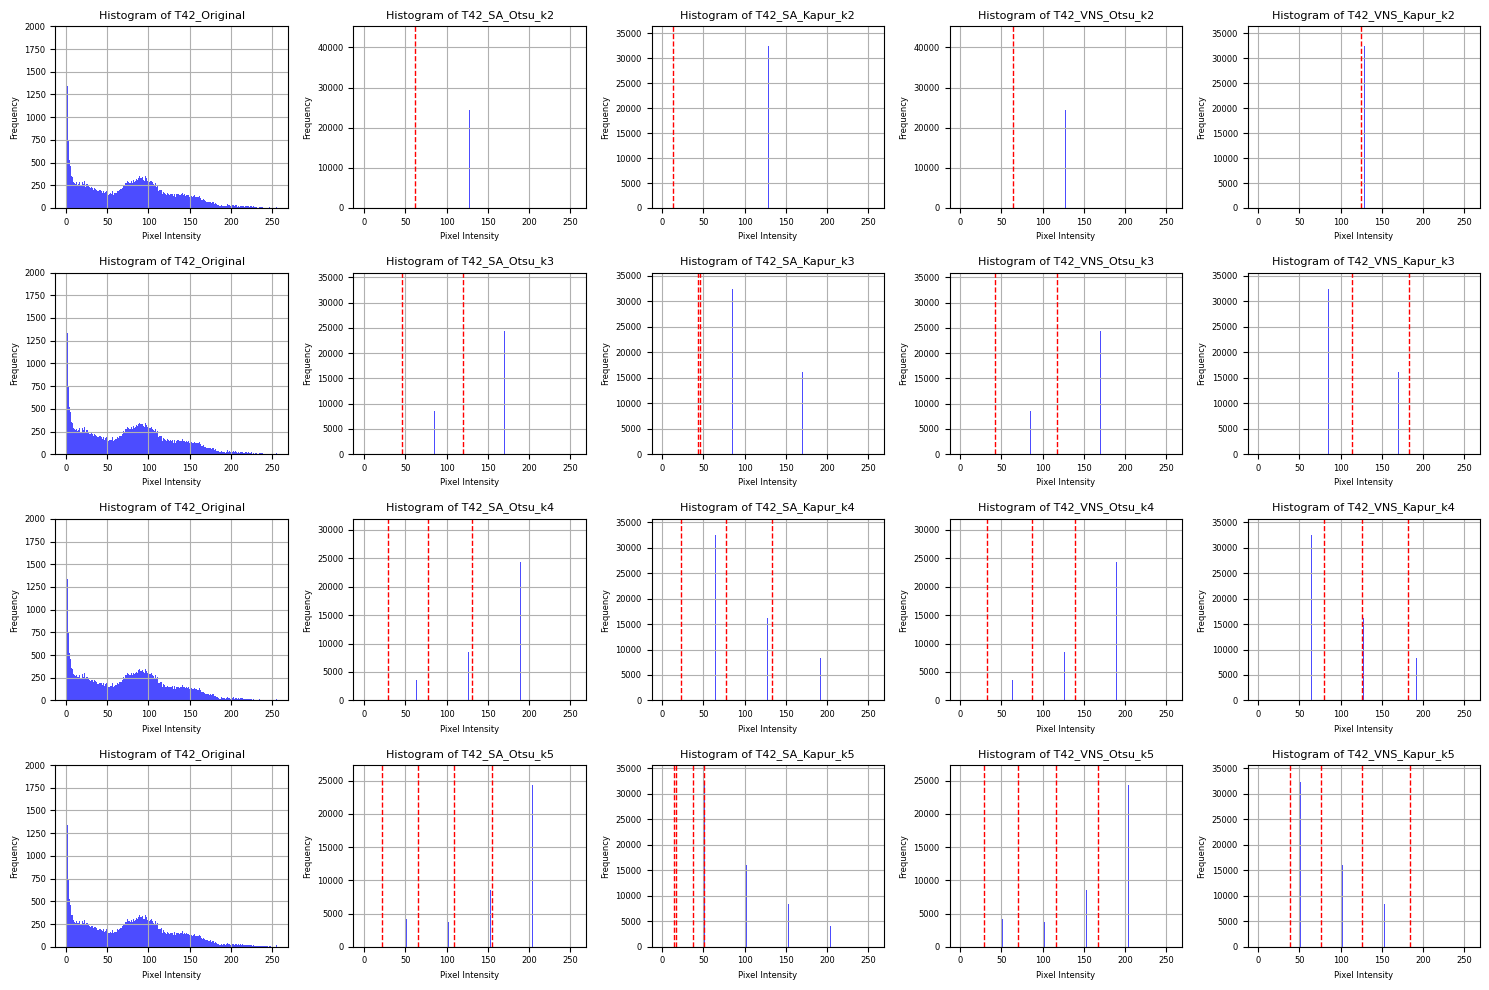

******** Processing image: T52.jpg ********
### Processing k=2 ###
Thresholds for T52_SA_Otsu_k2: [57]
Unique values for T52_SA_Otsu_k2: [  0 127]
Thresholds for T52_SA_Kapur_k2: [124]
Unique values for T52_SA_Kapur_k2: [  0 128 255]
Thresholds for T52_VNS_Otsu_k2: [61]
Unique values for T52_VNS_Otsu_k2: [  0 127]
Thresholds for T52_VNS_Kapur_k2: [125]
Unique values for T52_VNS_Kapur_k2: [  0 128 255]
### Processing k=3 ###
Thresholds for T52_SA_Otsu_k3: [ 45 112]
Unique values for T52_SA_Otsu_k3: [  0  85 170]
Thresholds for T52_SA_Kapur_k3: [145   3]
Unique values for T52_SA_Kapur_k3: [  0  85 170 255]
Thresholds for T52_VNS_Otsu_k3: [ 44 111]
Unique values for T52_VNS_Otsu_k3: [  0  85 170]
Thresholds for T52_VNS_Kapur_k3: [121 188]
Unique values for T52_VNS_Kapur_k3: [  0  85 170 255]
### Processing k=4 ###
Thresholds for T52_SA_Otsu_k4: [ 36  86 129]
Unique values for T52_SA_Otsu_k4: [  0  63 126 189]
Thresholds for T52_SA_Kapur_k4: [ 4 20 32]
Unique values for T52_SA_Kapur_k4: [ 

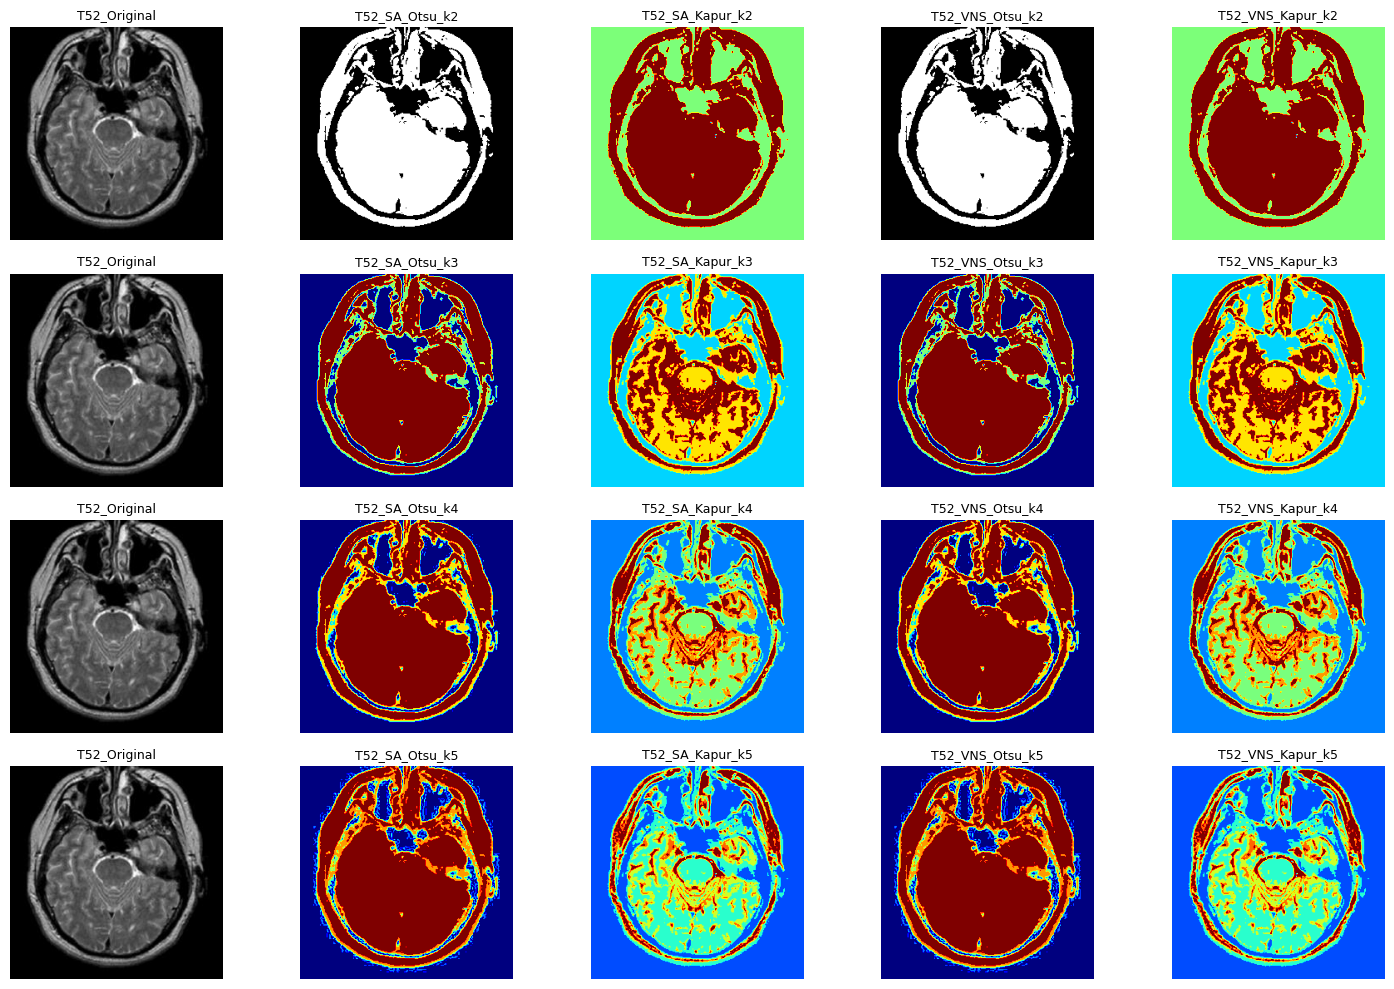

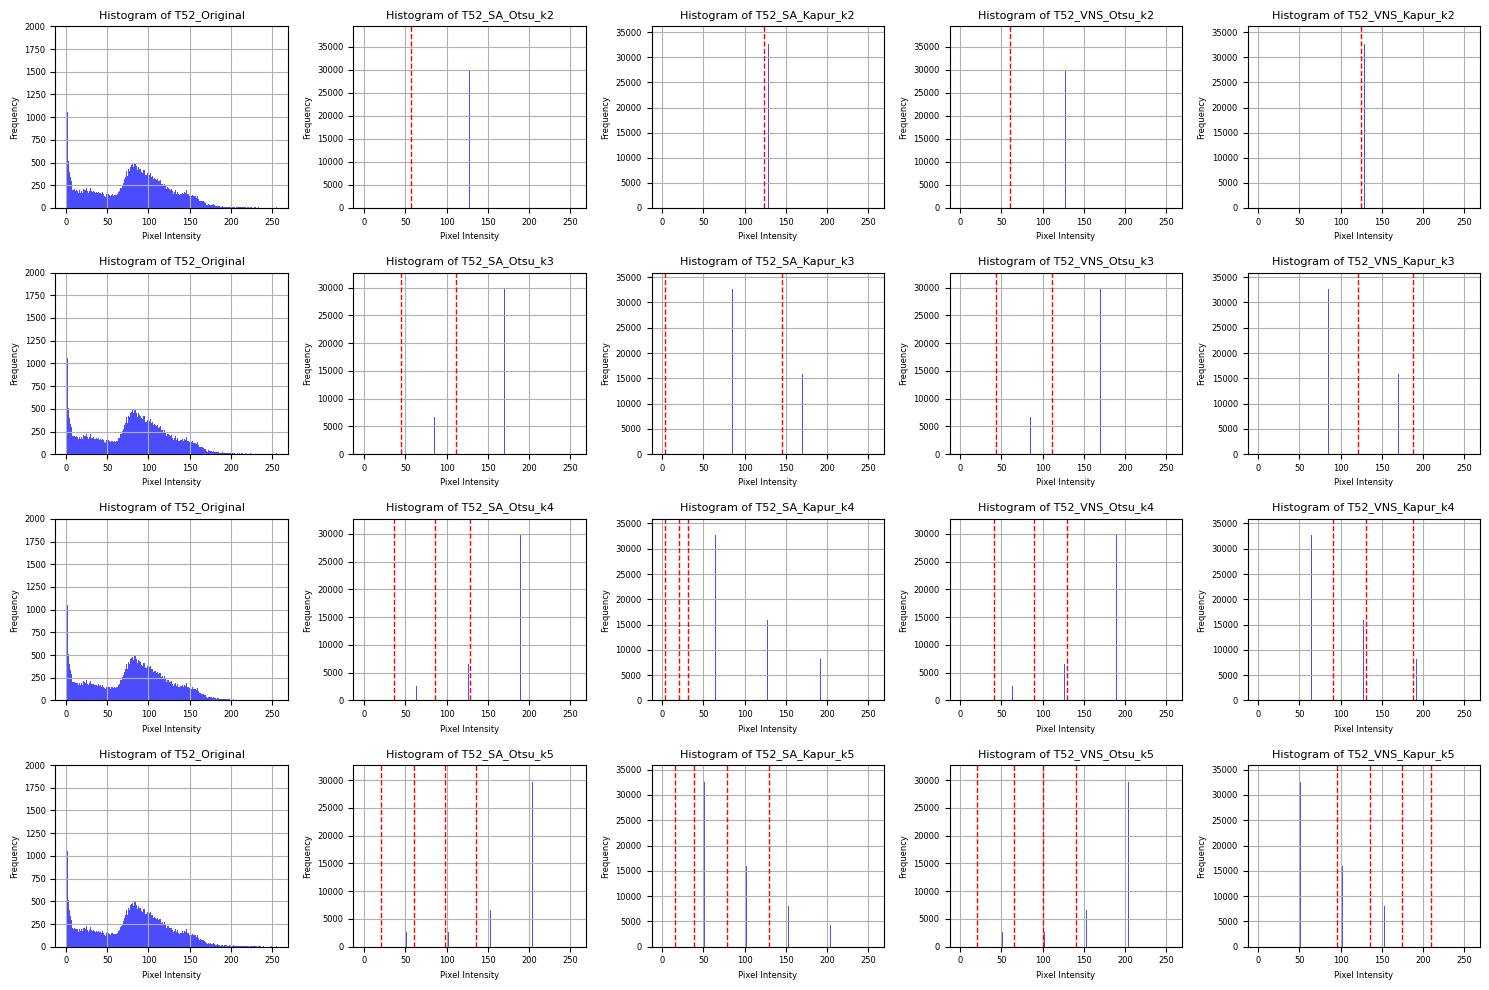

******** Processing image: T62.jpg ********
### Processing k=2 ###
Thresholds for T62_SA_Otsu_k2: [60]
Unique values for T62_SA_Otsu_k2: [  0 127]
Thresholds for T62_SA_Kapur_k2: [117]
Unique values for T62_SA_Kapur_k2: [  0 128 255]
Thresholds for T62_VNS_Otsu_k2: [56]
Unique values for T62_VNS_Otsu_k2: [  0 127]
Thresholds for T62_VNS_Kapur_k2: [177]
Unique values for T62_VNS_Kapur_k2: [  0 128 255]
### Processing k=3 ###
Thresholds for T62_SA_Otsu_k3: [ 47 121]
Unique values for T62_SA_Otsu_k3: [  0  85 170]
Thresholds for T62_SA_Kapur_k3: [20 95]
Unique values for T62_SA_Kapur_k3: [  0  85 170 255]
Thresholds for T62_VNS_Otsu_k3: [ 46 119]
Unique values for T62_VNS_Otsu_k3: [  0  85 170]
Thresholds for T62_VNS_Kapur_k3: [120 184]
Unique values for T62_VNS_Kapur_k3: [  0  85 170 255]
### Processing k=4 ###
Thresholds for T62_SA_Otsu_k4: [ 40  96 145]
Unique values for T62_SA_Otsu_k4: [  0  63 126 189]
Thresholds for T62_SA_Kapur_k4: [63 37 93]
Unique values for T62_SA_Kapur_k4: [  0

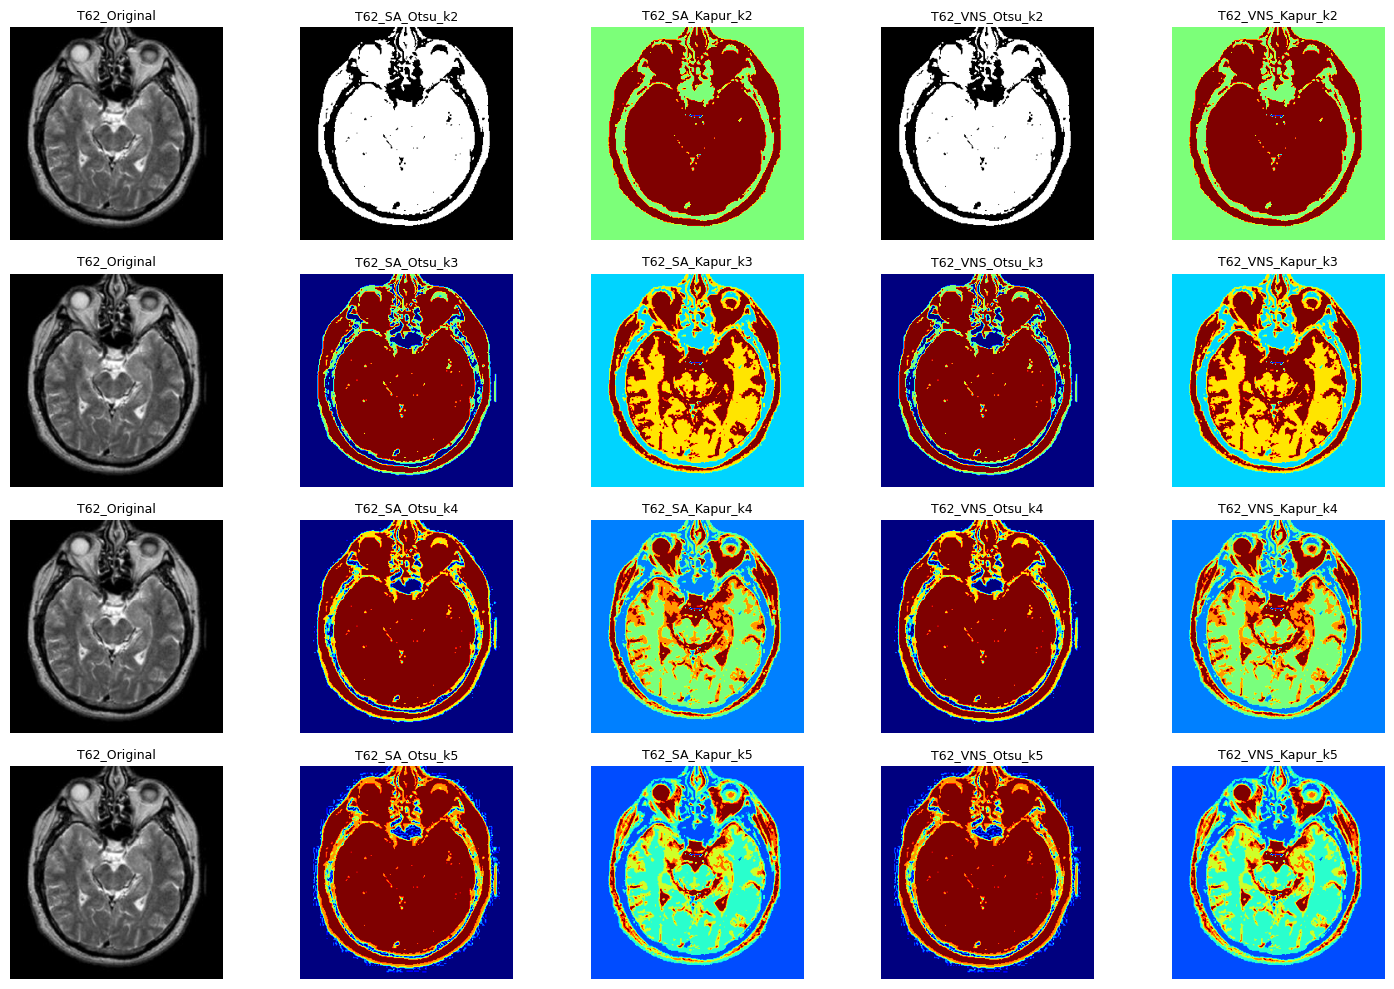

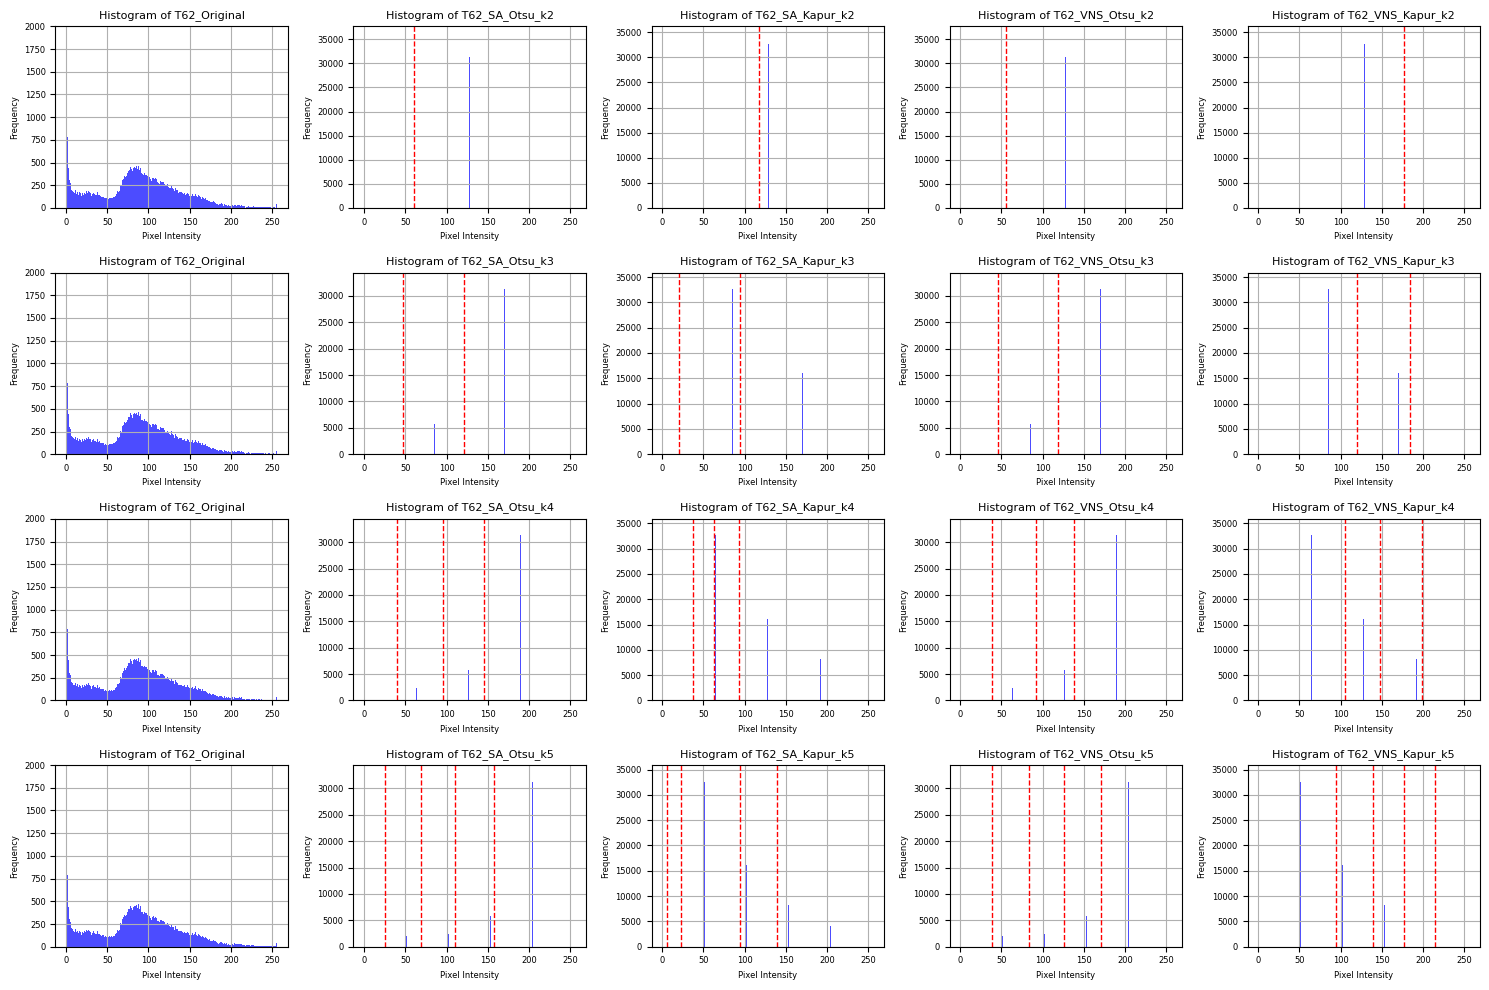

Image Level Method                  Optimization           Thresholds  \
0    T22     2   Otsu           Simulated Annealing                 [60]   
1    T22     2  Kapur           Simulated Annealing                 [31]   
2    T22     2   Otsu  Variable Neighborhood Search                 [58]   
3    T22     2  Kapur  Variable Neighborhood Search                [105]   
4    T22     3   Otsu           Simulated Annealing             [33, 94]   
..   ...   ...    ...                           ...                  ...   
75   T62     4  Kapur  Variable Neighborhood Search      [105, 148, 199]   
76   T62     5   Otsu           Simulated Annealing   [25, 69, 110, 157]   
77   T62     5  Kapur           Simulated Annealing     [6, 23, 139, 95]   
78   T62     5   Otsu  Variable Neighborhood Search   [39, 83, 126, 171]   
79   T62     5  Kapur  Variable Neighborhood Search  [94, 139, 177, 214]   

    Objective Value      SSIM       PSNR                Unique Values  
0      3.249957e+07  0.606568  19.619709                     [0, 127]  
1     -6.633826e+00  0.422429   5.810659                     [0, 255]  
2      3.256640e+07  0.606568  19.619709                     [0, 127]  
3     -7.439700e+00  0.422429   5.810659                     [0, 255]  
4      1.417122e+07  0.641719  15.256310                 [0, 85, 170]  
..              ...       ...        ...                          ...  
75    -1.445612e+01  0.396742  11.590330       [0, 64, 127, 191, 255]  
76     7.814726e+06  0.472840  10.122377       [0, 51, 102, 153, 204]  
77    -1.550653e+01  0.462044  14.613139  [0, 51, 102, 153, 204, 255]  
78     8.393162e+06  0.472840  10.122377       [0, 51, 102, 153, 204]  
79    -1.739745e+01  0.462044  14.613139  [0, 51, 102, 153, 204, 255]  

[80 rows x 9 columns]

Results have been logged and saved to 'processed_results.csv'.


In [186]:
# this function is to plot the histogram of the specified image
def plot_histogram(image, title):
    plt.figure(figsize=(6, 4))
    plt.hist(image.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
    plt.title(f'Gray Level Histogram of {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# this is the main execution block for image processing with results logging
for filename, image in images:
    name_without_extension = os.path.splitext(filename)[0]
    print(f"******** Processing image: {filename} ********")
    
    processed_images = []  
    image_titles = []    
    thresholds_list = []  

    # for loop to loop through all specified k levels
    for k in [2, 3, 4, 5]:
        print(f"### Processing k={k} ###")
        
        # Append the original image before each row of processed images
        original_image = image.copy() 
        processed_images.append(original_image)
        image_titles.append(f'{name_without_extension}_Original')
        thresholds_list.append(None) 

        # this section calls all functionality for the Simulated Annealing + Otsu
        sa_otsu_thresholds = simulated_annealing(image, otsu_objective, k)
        segmented_sa_otsu, _ = otsu_multilevel_thresholding(image, len(sa_otsu_thresholds) + 1)
        ssim_sa_otsu = ssim(image, segmented_sa_otsu)
        psnr_sa_otsu = psnr(image, segmented_sa_otsu)
        otsu_obj_value = otsu_objective(image, sa_otsu_thresholds)  # calculating objective value
        print(f"Thresholds for {name_without_extension}_SA_Otsu_k{k}: {sa_otsu_thresholds}") 
        print(f"Unique values for {name_without_extension}_SA_Otsu_k{k}: {np.unique(segmented_sa_otsu)}")
        results_df = log_results(results_df, name_without_extension, k, "Otsu", "Simulated Annealing", sa_otsu_thresholds, otsu_obj_value, ssim_sa_otsu, psnr_sa_otsu, np.unique(segmented_sa_otsu).tolist())
        processed_images.append(segmented_sa_otsu)
        image_titles.append(f'{name_without_extension}_SA_Otsu_k{k}')
        thresholds_list.append(sa_otsu_thresholds)
        
        # this section calls all functionality for the Simulated Annealing + Kapur
        sa_kapur_thresholds = simulated_annealing(image, kapur_objective, k)
        segmented_sa_kapur, _ = kapur_threshold(image, len(sa_kapur_thresholds) + 1)
        ssim_sa_kapur = ssim(image, segmented_sa_kapur)
        psnr_sa_kapur = psnr(image, segmented_sa_kapur)
        kapur_obj_value = kapur_objective(image, sa_kapur_thresholds)  
        print(f"Thresholds for {name_without_extension}_SA_Kapur_k{k}: {sa_kapur_thresholds}") 
        print(f"Unique values for {name_without_extension}_SA_Kapur_k{k}: {np.unique(segmented_sa_kapur)}")
        results_df = log_results(results_df, name_without_extension, k, "Kapur", "Simulated Annealing", sa_kapur_thresholds, kapur_obj_value, ssim_sa_kapur, psnr_sa_kapur, np.unique(segmented_sa_kapur).tolist())
        processed_images.append(segmented_sa_kapur)
        image_titles.append(f'{name_without_extension}_SA_Kapur_k{k}')
        thresholds_list.append(sa_kapur_thresholds)

        # this section calls all functionality for the Variable Neighbourhood Search + Otsu
        vns_otsu_thresholds = variable_neighborhood_search(image, otsu_objective, k)
        segmented_vns_otsu, _ = otsu_multilevel_thresholding(image, len(vns_otsu_thresholds) + 1)
        ssim_vns_otsu = ssim(image, segmented_vns_otsu)
        psnr_vns_otsu = psnr(image, segmented_vns_otsu)
        otsu_obj_value_vns = otsu_objective(image, vns_otsu_thresholds) 
        print(f"Thresholds for {name_without_extension}_VNS_Otsu_k{k}: {vns_otsu_thresholds}")  
        print(f"Unique values for {name_without_extension}_VNS_Otsu_k{k}: {np.unique(segmented_vns_otsu)}")
        results_df = log_results(results_df, name_without_extension, k, "Otsu", "Variable Neighborhood Search", vns_otsu_thresholds, otsu_obj_value_vns, ssim_vns_otsu, psnr_vns_otsu, np.unique(segmented_vns_otsu).tolist())
        processed_images.append(segmented_vns_otsu)
        image_titles.append(f'{name_without_extension}_VNS_Otsu_k{k}')
        thresholds_list.append(vns_otsu_thresholds)
        
        # this section calls all functionality for the Variable Neighbourhood Search + Kapur
        vns_kapur_thresholds = variable_neighborhood_search(image, kapur_objective, k)
        segmented_vns_kapur, _ = kapur_threshold(image, len(vns_kapur_thresholds) + 1)
        ssim_vns_kapur = ssim(image, segmented_vns_kapur)
        psnr_vns_kapur = psnr(image, segmented_vns_kapur)
        kapur_obj_value_vns = kapur_objective(image, vns_kapur_thresholds)  
        print(f"Thresholds for {name_without_extension}_VNS_Kapur_k{k}: {vns_kapur_thresholds}")  
        print(f"Unique values for {name_without_extension}_VNS_Kapur_k{k}: {np.unique(segmented_vns_kapur)}")
        results_df = log_results(results_df, name_without_extension, k, "Kapur", "Variable Neighborhood Search", vns_kapur_thresholds, kapur_obj_value_vns, ssim_vns_kapur, psnr_vns_kapur, np.unique(segmented_vns_kapur).tolist())
        processed_images.append(segmented_vns_kapur)
        image_titles.append(f'{name_without_extension}_VNS_Kapur_k{k}')
        thresholds_list.append(vns_kapur_thresholds)

    # displaying original image and processed images as well as histograms associated with each image
    display_images(processed_images, image_titles, cols=5, figsize=(15, 10))
    display_histograms(processed_images, image_titles, thresholds_list=thresholds_list, cols=5, figsize=(15, 10))

# ! this is to save results to a csv file
# outputting results from dataframe
display(results_df)

# saving results in a csv file
results_df.to_csv('processed_results.csv', index=False)

print("Results have been logged and saved to 'processed_results.csv'.")                                                                                                                                        